In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- Unzip the dataset ---
# IMPORTANT: Update this path to match the location of your zip file in Drive.
zip_path = '/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/ffhq256_10ksubset.zip'

# The destination folder in the local Colab environment.
destination_path = '/content'

print("Unzipping dataset...")
# The -q flag makes the output cleaner (quiet mode)
!unzip -q {zip_path} -d {destination_path}

print(f"✅ Dataset unzipped to {destination_path}")

Unzipping dataset...
✅ Dataset unzipped to /content


In [3]:
# Install
!pip -q install pytorch_wavelets torchmetrics lpips torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch._dynamo
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
import pandas as pd
import time
import random
import math
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
import os
import glob
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

import torch.fft
from pytorch_wavelets import DWTForward
from einops import rearrange

# Enable TensorFloat32
torch.set_float32_matmul_precision('high')

# --- Configuration & Hyperparameters ---

# Set the path to your image folder in Google Drive
# IMPORTANT: Update this path to match where you saved your dataset.
DATASET_PATH = '/content/ffhq_subset_10k'
NUM_IMAGES_TO_USE_CNN = 10000
NUM_IMAGES_TO_USE_GAN = 1000

# Training settings
NUM_EPOCHS_CNN = 40
NUM_EPOCHS_GAN = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

# Set the device (use GPU if available)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
class FFHQDataset(Dataset):
    """Custom PyTorch Dataset for loading FFHQ images."""
    def __init__(self, img_dir, transform=None, num_images=None): # Add num_images parameter
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_images (int, optional): Number of images to use. If None, use all images.
        """
        # Find all files with .png or .jpg extension
        self.img_paths = glob.glob(os.path.join(img_dir, '*.png'))
        self.img_paths.extend(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.transform = transform

        if num_images:
            # If a number is specified, shuffle all paths and take a random subset
            random.shuffle(self.img_paths)
            self.img_paths = self.img_paths[:num_images]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Your transform definition remains the same
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
class SelfAttention(nn.Module):
    """ A simple self-attention layer """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        q = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, width * height)
        v = self.value(x).view(batch_size, -1, width * height)

        attention_map = F.softmax(torch.bmm(q, k), dim=-1)

        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x # Add skip connection

class UpsampleBlock(nn.Module):
    """An upsampling block using Conv2d and PixelShuffle."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The Conv2d layer produces 4x the channels for a 2x upscale
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2) # Rearranges channels to upscale by 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class GatedConv2d(nn.Module):
    """
    A Gated Convolutional Layer.
    It learns a dynamic feature mask for each channel at every location.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        # Convolution for the features
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )
        # Convolution for the gating mechanism
        self.conv_gate = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )

    def forward(self, x):
        # Get the features and the gate
        features = self.conv_feature(x)
        gate = torch.sigmoid(self.conv_gate(x)) # Gate values are between 0 and 1

        # Element-wise multiplication to apply the learned gate
        return features * gate

class GatedResidualBlock(nn.Module):
    """A Residual Block that uses Gated Convolutions."""
    def __init__(self, channels, dilation=1):
        super().__init__()
        padding = dilation

        # Replace nn.Conv2d with GatedConv2d
        self.conv1 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class UNetSR(nn.Module):
    """
    A U-Net architecture with corrected channel dimensions for the decoder.
    """
    def __init__(self, in_channels=4, out_channels=3, num_channels=64):
        super().__init__()

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)

        # --- Encoder Path ---
        self.enc1 = GatedResidualBlock(num_channels, dilation=1)
        self.enc2 = GatedResidualBlock(num_channels, dilation=1)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck with Dilation and Attention ---
        self.bottleneck = nn.Sequential(
            GatedResidualBlock(num_channels, dilation=2),
            # SelfAttention(num_channels), # Add attention layer
            GatedResidualBlock(num_channels, dilation=4)
        )

        # --- Decoder Path ---
        self.upconv2 = UpsampleBlock(num_channels, num_channels)
        # Input channels = upsampled (64) + skip connection from e2 (64) = 128
        self.dec2 = GatedResidualBlock(num_channels * 2, dilation=1)

        self.upconv1 = UpsampleBlock(num_channels * 2, num_channels)
        # Input channels = upsampled (64) + skip connection from e1 (64) = 128
        self.dec1 = GatedResidualBlock(num_channels * 2, dilation=1)

        # --- Final Output Layer ---
        # The input to this layer comes from dec1, which outputs 128 channels.
        self.out_conv = nn.Conv2d(num_channels * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        x0 = self.init_conv(x)

        # Encoder
        e1 = self.enc1(x0)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder with Skip Connections
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final Output
        out = self.out_conv(d1)

        return torch.tanh(out)

In [7]:
# --- 1. Create the main dataset ---
# This should use the LARGER number of images you intend to work with.
# Let's assume NUM_IMAGES_TO_USE_CNN is the total pool of images.
print("Creating the main dataset...")
full_dataset = FFHQDataset(
    img_dir=DATASET_PATH,
    transform=transform,
    num_images=NUM_IMAGES_TO_USE_CNN # Use the total number of images available for the experiment
)
print(f"✅ Main dataset created with {len(full_dataset)} images.")

# --- 2. Split the dataset into Training, Validation, and Test sets ---
print("\nSplitting data into training, validation, and test sets...")
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.seed(42) # for reproducibility
np.random.shuffle(indices)

# Define split points for an 80/10/10 split
train_split = int(np.floor(0.8 * dataset_size))
val_split = int(np.floor(0.9 * dataset_size))

# Create indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create PyTorch Subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"✅ Training set size: {len(train_data)}")
print(f"✅ Validation set size: {len(val_data)}")
print(f"✅ Test set size: {len(test_data)}")

# --- 3. Create the Diffusion Model's training subset ---
# This should be a subset of the TRAINING data.
print("\nCreating a subset of the training data for the GAN model...")
gan_indices = train_indices[:NUM_IMAGES_TO_USE_GAN] # Take from the start of shuffled train indices
gan_data = Subset(full_dataset, gan_indices)
print(f"✅ Diffusion training set size: {len(gan_data)}")


# --- 4. Create DataLoaders for each set ---
print("\nCreating DataLoaders...")
# The main CNN will now train on the 'train_data' subset
cnn_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# New DataLoader for validation
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)
# New DataLoader for testing
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)
# GAN DataLoader uses its own subset of the training data
gan_dataloader = DataLoader(
    gan_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)
print("✅ All DataLoaders created.")

# --- 5. Initialize models and optimizers (unchanged) ---
print("\nInitializing models and optimizers...")
cnn_model = UNetSR().to(DEVICE)

# Compile the models for a speed boost
cnn_model = torch.compile(cnn_model)

# Initialize optimizers
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print("\nSetup complete. Ready for CNN training!")

Creating the main dataset...
✅ Main dataset created with 10000 images.

Splitting data into training, validation, and test sets...
✅ Training set size: 8000
✅ Validation set size: 1000
✅ Test set size: 1000

Creating a subset of the training data for the GAN model...
✅ Diffusion training set size: 1000

Creating DataLoaders...
✅ All DataLoaders created.

Initializing models and optimizers...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Setup complete. Ready for CNN training!


In [10]:
def create_variable_mask(images, mask_percentage):
    """
    Create masks with specified percentage of image area
    Args:
        images: [B, C, H, W] tensor
        mask_percentage: float between 0 and 1 (e.g., 0.025 for 2.5%)
    """
    batch_size, _, height, width = images.shape
    masks = torch.ones_like(images)

    for i in range(batch_size):
        # Calculate mask size
        total_pixels = height * width
        mask_pixels = int(total_pixels * mask_percentage)

        # Create random mask (you can also use square/irregular masks)
        if mask_percentage < 0.1:  # For small masks, use squares
            # Square mask
            mask_size = int(np.sqrt(mask_pixels))
            top = np.random.randint(0, height - mask_size)
            left = np.random.randint(0, width - mask_size)
            masks[i, :, top:top+mask_size, left:left+mask_size] = 0
        else:  # For larger masks, use irregular shapes
            # Multiple rectangles for more realistic patterns
            num_rects = np.random.randint(1, 5)
            pixels_per_rect = mask_pixels // num_rects

            for _ in range(num_rects):
                rect_h = np.random.randint(int(np.sqrt(pixels_per_rect)//2),
                                          min(int(np.sqrt(pixels_per_rect)*2), height//2))
                rect_w = pixels_per_rect // rect_h

                if rect_h < height and rect_w < width:
                    top = np.random.randint(0, max(1, height - rect_h))
                    left = np.random.randint(0, max(1, width - rect_w))
                    masks[i, :, top:min(top+rect_h, height), left:min(left+rect_w, width)] = 0

    masked_images = images * masks
    return masked_images, masks

def evaluate_cnn_multiple_masks(cnn_model, test_loader, mask_percentages, device='cuda', num_batches=None):
    """
    Evaluate CNN performance with different mask sizes

    Args:
        cnn_model: Your trained CNN model
        test_loader: DataLoader with test images
        mask_percentages: List of mask percentages to test (e.g., [0.025, 0.05, 0.1, 0.2, 0.4])
        device: cuda or cpu
        num_batches: Number of batches to evaluate (None for all)
    """

    cnn_model.eval()
    results = {pct: {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [],
                     'psnr_hole': [], 'mae_hole': []}
               for pct in mask_percentages}

    # Initialize metrics
    psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    lpips_metric = lpips.LPIPS(net='alex').to(device)

    print("Evaluating CNN with varying mask sizes...")
    print("=" * 60)

    for mask_pct in mask_percentages:
        print(f"\nTesting with {mask_pct*100:.1f}% mask...")

        batch_count = 0
        for batch_idx, batch in enumerate(tqdm(test_loader, desc=f"Mask {mask_pct*100:.1f}%")):
            if num_batches and batch_idx >= num_batches:
                break

            original_images = batch.to(device)

            with torch.no_grad():
                # Create masks with current percentage
                masked_images, masks = create_variable_mask(original_images, mask_pct)
                masks = masks.to(device)

                # CNN inference
                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                cnn_output = cnn_model(cnn_input)

                # Ensure output is in proper range
                cnn_output = torch.clamp(cnn_output, -1, 1)

                # Convert to [0, 1] for metrics
                original_01 = (original_images + 1) / 2
                output_01 = (cnn_output + 1) / 2

                # === WHOLE IMAGE METRICS ===
                results[mask_pct]['psnr'].append(psnr_metric(output_01, original_01).item())
                results[mask_pct]['ssim'].append(ssim_metric(output_01, original_01).item())
                results[mask_pct]['lpips'].append(lpips_metric(cnn_output, original_images).mean().item())
                results[mask_pct]['mae'].append(F.l1_loss(output_01, original_01).item())

                # === HOLE-ONLY METRICS ===
                hole_mask = 1 - masks[:, 0:1]
                if hole_mask.sum() > 0:
                    # PSNR for inpainted region only
                    mse_hole = ((output_01 * hole_mask - original_01 * hole_mask) ** 2).sum() / hole_mask.sum()
                    psnr_hole = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse_hole)
                    results[mask_pct]['psnr_hole'].append(psnr_hole.item())

                    # MAE for inpainted region only
                    mae_hole = (F.l1_loss(output_01 * hole_mask, original_01 * hole_mask, reduction='sum') / hole_mask.sum()).item()
                    results[mask_pct]['mae_hole'].append(mae_hole)
                else:
                    results[mask_pct]['psnr_hole'].append(results[mask_pct]['psnr'][-1])
                    results[mask_pct]['mae_hole'].append(results[mask_pct]['mae'][-1])

            batch_count += 1

    return results

def print_results_table(results):
    """Print results in a nice table format"""

    print("\n" + "=" * 80)
    print("CNN PERFORMANCE VS MASK SIZE - WHOLE IMAGE METRICS")
    print("=" * 80)

    # Prepare data for whole image metrics
    data_whole = []
    for mask_pct, metrics in results.items():
        data_whole.append({
            'Mask %': f"{mask_pct*100:.1f}%",
            'PSNR ↑': f"{np.mean(metrics['psnr']):.2f} ± {np.std(metrics['psnr']):.2f}",
            'SSIM ↑': f"{np.mean(metrics['ssim']):.4f} ± {np.std(metrics['ssim']):.4f}",
            'LPIPS ↓': f"{np.mean(metrics['lpips']):.4f} ± {np.std(metrics['lpips']):.4f}",
            'MAE ↓': f"{np.mean(metrics['mae']):.4f} ± {np.std(metrics['mae']):.4f}",
        })

    df_whole = pd.DataFrame(data_whole)
    print(df_whole.to_string(index=False))

    print("\n" + "=" * 80)
    print("CNN PERFORMANCE VS MASK SIZE - INPAINTED REGION ONLY")
    print("=" * 80)

    # Prepare data for hole metrics
    data_hole = []
    for mask_pct, metrics in results.items():
        data_hole.append({
            'Mask %': f"{mask_pct*100:.1f}%",
            'PSNR (hole) ↑': f"{np.mean(metrics['psnr_hole']):.2f} ± {np.std(metrics['psnr_hole']):.2f}",
            'MAE (hole) ↓': f"{np.mean(metrics['mae_hole']):.4f} ± {np.std(metrics['mae_hole']):.4f}",
        })

    df_hole = pd.DataFrame(data_hole)
    print(df_hole.to_string(index=False))

def create_performance_plots(results, save_path='cnn_mask_performance.png'):
    """Create visualization of performance vs mask size"""

    mask_sizes = sorted(results.keys())
    mask_percentages = [m * 100 for m in mask_sizes]

    # Extract mean values
    psnr_means = [np.mean(results[m]['psnr']) for m in mask_sizes]
    psnr_stds = [np.std(results[m]['psnr']) for m in mask_sizes]

    ssim_means = [np.mean(results[m]['ssim']) for m in mask_sizes]
    ssim_stds = [np.std(results[m]['ssim']) for m in mask_sizes]

    lpips_means = [np.mean(results[m]['lpips']) for m in mask_sizes]
    lpips_stds = [np.std(results[m]['lpips']) for m in mask_sizes]

    psnr_hole_means = [np.mean(results[m]['psnr_hole']) for m in mask_sizes]
    psnr_hole_stds = [np.std(results[m]['psnr_hole']) for m in mask_sizes]

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # PSNR vs Mask Size
    axes[0, 0].errorbar(mask_percentages, psnr_means, yerr=psnr_stds,
                       marker='o', capsize=5, capthick=2, linewidth=2)
    axes[0, 0].set_xlabel('Mask Size (%)')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].set_title('PSNR vs Mask Size (Whole Image)')
    axes[0, 0].grid(True, alpha=0.3)

    # SSIM vs Mask Size
    axes[0, 1].errorbar(mask_percentages, ssim_means, yerr=ssim_stds,
                       marker='s', capsize=5, capthick=2, linewidth=2, color='green')
    axes[0, 1].set_xlabel('Mask Size (%)')
    axes[0, 1].set_ylabel('SSIM')
    axes[0, 1].set_title('SSIM vs Mask Size (Whole Image)')
    axes[0, 1].grid(True, alpha=0.3)

    # LPIPS vs Mask Size
    axes[1, 0].errorbar(mask_percentages, lpips_means, yerr=lpips_stds,
                       marker='^', capsize=5, capthick=2, linewidth=2, color='red')
    axes[1, 0].set_xlabel('Mask Size (%)')
    axes[1, 0].set_ylabel('LPIPS (lower is better)')
    axes[1, 0].set_title('LPIPS vs Mask Size')
    axes[1, 0].grid(True, alpha=0.3)

    # PSNR Hole vs Mask Size
    axes[1, 1].errorbar(mask_percentages, psnr_hole_means, yerr=psnr_hole_stds,
                       marker='d', capsize=5, capthick=2, linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Mask Size (%)')
    axes[1, 1].set_ylabel('PSNR (dB)')
    axes[1, 1].set_title('PSNR vs Mask Size (Inpainted Region Only)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('CNN Inpainting Performance vs Mask Size', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPlots saved to {save_path}")

def create_visual_comparison(cnn_model, test_loader, mask_percentages, device='cuda',
                            save_path='mask_size_visual_comparison.png'):
    """Create visual comparison showing results with different mask sizes"""

    # Get one sample image
    sample_batch = next(iter(test_loader))
    sample_image = sample_batch[0:1].to(device)

    fig, axes = plt.subplots(3, len(mask_percentages), figsize=(4*len(mask_percentages), 12))

    cnn_model.eval()

    with torch.no_grad():
        for idx, mask_pct in enumerate(mask_percentages):
            # Create mask
            masked_image, mask = create_variable_mask(sample_image, mask_pct)
            mask = mask.to(device)

            # CNN inference
            cnn_input = torch.cat([masked_image, mask[:, 0:1]], dim=1)
            cnn_output = cnn_model(cnn_input)

            # Convert to displayable format
            def to_img(tensor):
                return ((tensor[0].cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0)

            # Row 1: Masked input
            axes[0, idx].imshow(to_img(masked_image))
            axes[0, idx].set_title(f'Masked ({mask_pct*100:.1f}%)')
            axes[0, idx].axis('off')

            # Row 2: CNN output
            axes[1, idx].imshow(to_img(cnn_output))
            axes[1, idx].set_title('CNN Output')
            axes[1, idx].axis('off')

            # Row 3: Error map
            error = torch.abs(cnn_output - sample_image).mean(dim=1, keepdim=True)
            axes[2, idx].imshow(error[0, 0].cpu(), cmap='hot', vmin=0, vmax=0.5)
            axes[2, idx].set_title('Error Map')
            axes[2, idx].axis('off')

    # Add row labels
    axes[0, 0].set_ylabel('Masked Input', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('CNN Output', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Error Map', fontsize=12, fontweight='bold')

    plt.suptitle('CNN Performance Across Different Mask Sizes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Visual comparison saved to {save_path}")

Loading CNN model...
✅ CNN model loaded successfully
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating CNN with varying mask sizes...

Testing with 2.5% mask...


Mask 2.5%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 5.0% mask...


Mask 5.0%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 10.0% mask...


Mask 10.0%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 20.0% mask...


Mask 20.0%:   0%|          | 0/250 [00:00<?, ?it/s]


CNN PERFORMANCE VS MASK SIZE - WHOLE IMAGE METRICS
Mask %       PSNR ↑          SSIM ↑         LPIPS ↓           MAE ↓
  2.5% 36.07 ± 2.00 0.9862 ± 0.0043 0.0122 ± 0.0027 0.0040 ± 0.0005
  5.0% 30.85 ± 1.59 0.9735 ± 0.0052 0.0290 ± 0.0047 0.0069 ± 0.0010
 10.0% 28.12 ± 1.49 0.9533 ± 0.0070 0.0522 ± 0.0072 0.0108 ± 0.0017
 20.0% 23.26 ± 1.26 0.9046 ± 0.0107 0.1162 ± 0.0134 0.0242 ± 0.0039

CNN PERFORMANCE VS MASK SIZE - INPAINTED REGION ONLY
Mask % PSNR (hole) ↑    MAE (hole) ↓
  2.5%  15.45 ± 2.10 0.1987 ± 0.0458
  5.0%  13.11 ± 1.61 0.2780 ± 0.0525
 10.0%  13.22 ± 1.48 0.2659 ± 0.0477
 20.0%  11.18 ± 1.21 0.3565 ± 0.0548


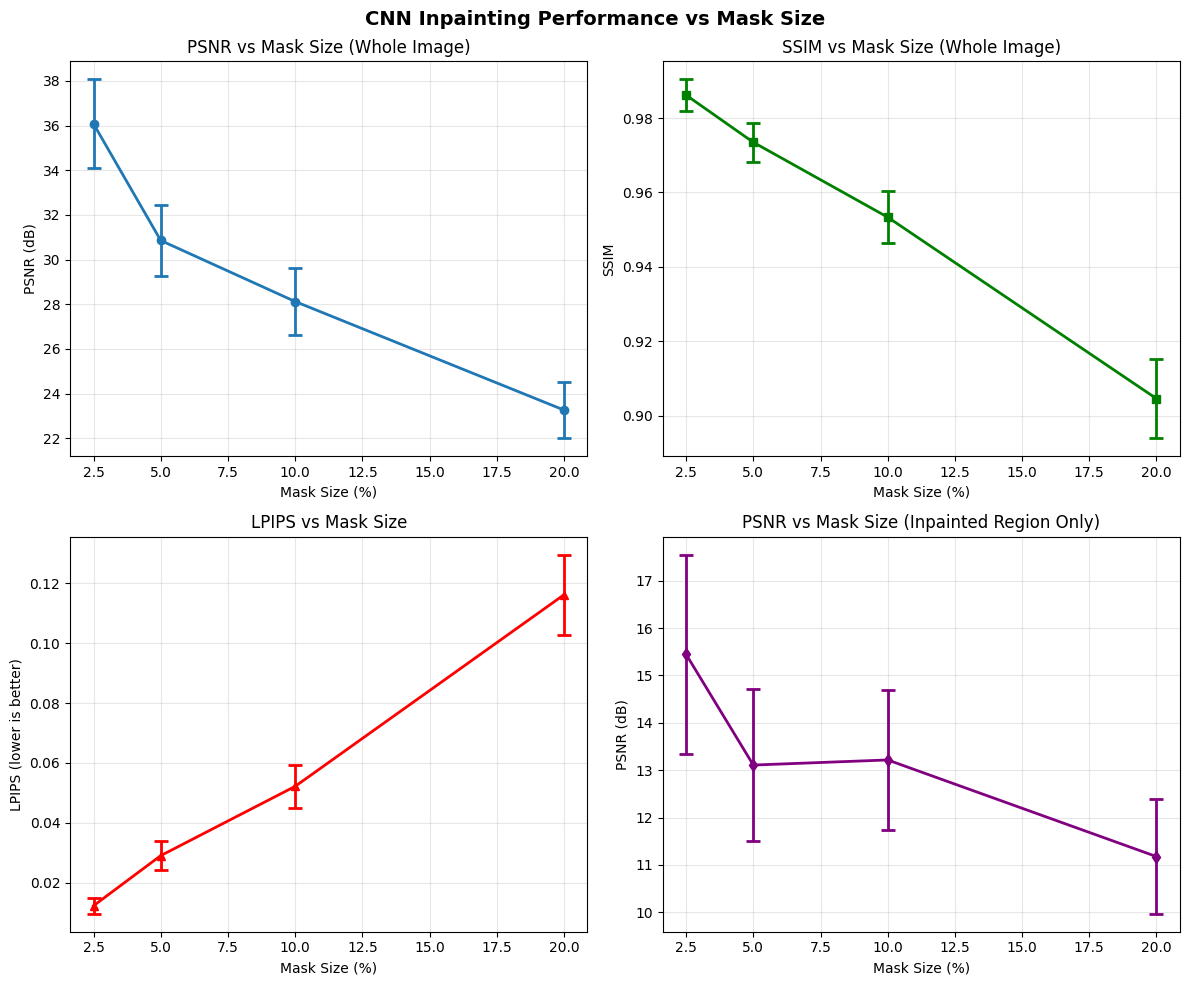


Plots saved to cnn_mask_performance.png


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


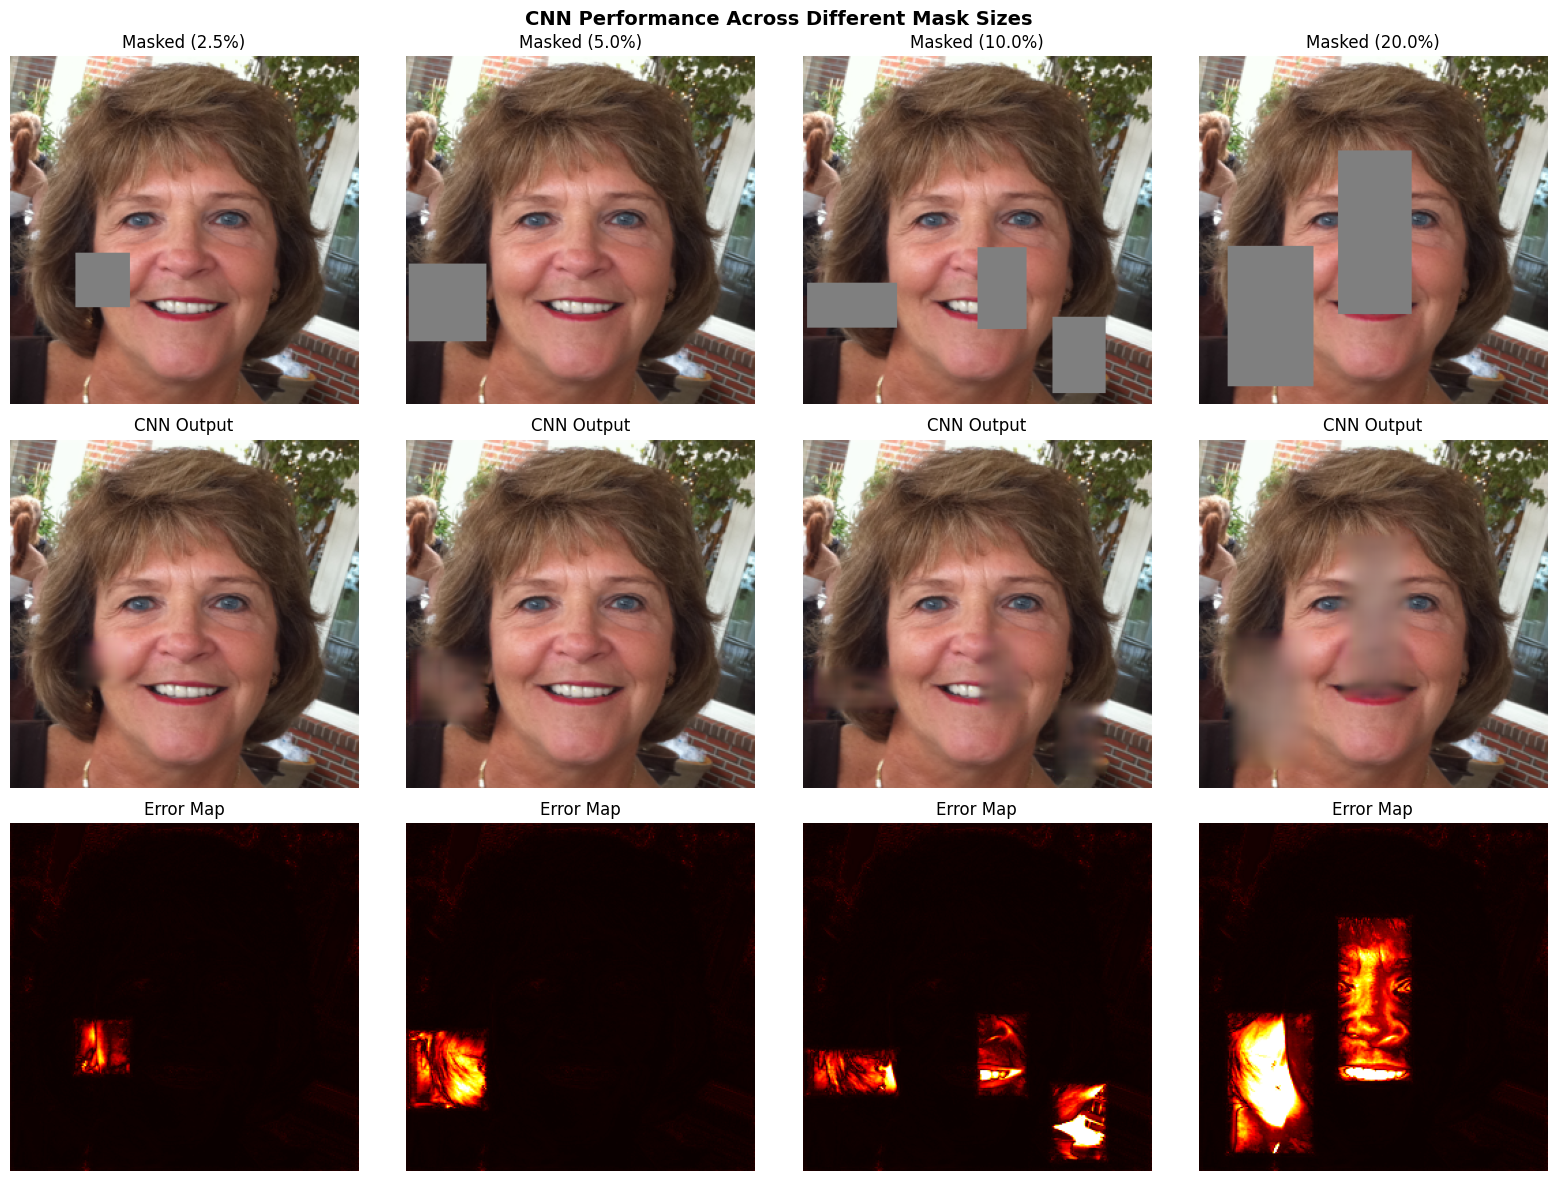

Visual comparison saved to mask_size_visual_comparison.png

Saving detailed results to CSV...
✅ Results saved to cnn_mask_evaluation_detailed.csv

EVALUATION COMPLETE
Tested mask sizes: ['2.5%', '5.0%', '10.0%', '20.0%']
Number of test batches: 250

Key Findings:
   2.5% mask → PSNR: 36.07 dB
   5.0% mask → PSNR: 30.85 dB
  10.0% mask → PSNR: 28.12 dB
  20.0% mask → PSNR: 23.26 dB


In [11]:
# ===========================================
# MAIN EXECUTION
# ===========================================

# Define mask percentages to test
MASK_PERCENTAGES = [0.025, 0.05, 0.1, 0.2]  # 2.5%, 5%, 10%, 20%

# Load your CNN model
print("Loading CNN model...")
cnn_model = UNetSR(in_channels=4, out_channels=3).to(DEVICE)
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)
cnn_model.eval()
print("✅ CNN model loaded successfully")

# Run evaluation
results = evaluate_cnn_multiple_masks(
    cnn_model=cnn_model,
    test_loader=test_dataloader,
    mask_percentages=MASK_PERCENTAGES,
    device=DEVICE,
    num_batches=None  # Use 50 batches for faster testing, or None for full test set
)

# Print results
print_results_table(results)

# Create performance plots
create_performance_plots(results, save_path='cnn_mask_performance.png')

# Create visual comparison
create_visual_comparison(
    cnn_model=cnn_model,
    test_loader=test_dataloader,
    mask_percentages=MASK_PERCENTAGES,
    device=DEVICE,
    save_path='mask_size_visual_comparison.png'
)

# Save results to CSV for further analysis
print("\nSaving detailed results to CSV...")
detailed_results = []
for mask_pct in MASK_PERCENTAGES:
    for i in range(len(results[mask_pct]['psnr'])):
        detailed_results.append({
            'mask_percentage': mask_pct * 100,
            'psnr': results[mask_pct]['psnr'][i],
            'ssim': results[mask_pct]['ssim'][i],
            'lpips': results[mask_pct]['lpips'][i],
            'mae': results[mask_pct]['mae'][i],
            'psnr_hole': results[mask_pct]['psnr_hole'][i],
            'mae_hole': results[mask_pct]['mae_hole'][i],
        })

df_detailed = pd.DataFrame(detailed_results)
df_detailed.to_csv('cnn_mask_evaluation_detailed.csv', index=False)
print("✅ Results saved to cnn_mask_evaluation_detailed.csv")

# Print summary
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)
print(f"Tested mask sizes: {[f'{m*100:.1f}%' for m in MASK_PERCENTAGES]}")
print(f"Number of test batches: {len(results[MASK_PERCENTAGES[0]]['psnr'])}")
print("\nKey Findings:")
for mask_pct in MASK_PERCENTAGES:
    psnr_mean = np.mean(results[mask_pct]['psnr'])
    print(f"  {mask_pct*100:4.1f}% mask → PSNR: {psnr_mean:.2f} dB")